In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Festival date checker function
def is_festival_date(date):
    festival_dates = {
        'Pongal': [(1, 14), (1, 15)],
        'Tamil New Year': [(4, 14)],
        'Diwali': [(10, 24), (10, 25)],
        'Navaratri': [(10, 15)],
        'Christmas': [(12, 25)]
    }

    if isinstance(date, str):
        date = pd.to_datetime(date)

    for festival, date_ranges in festival_dates.items():
        for month_day in date_ranges:
            if date.month == month_day[0] and date.day == month_day[1]:
                return True
    return False

In [ ]:
# Load and prepare the dataset
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])

    # Feature engineering
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Is_Festival'] = df['Festival'].notna().astype(int)

    return df

# Load your data
df = load_and_prepare_data("dindigul_tomato_prices_enhanced.csv")

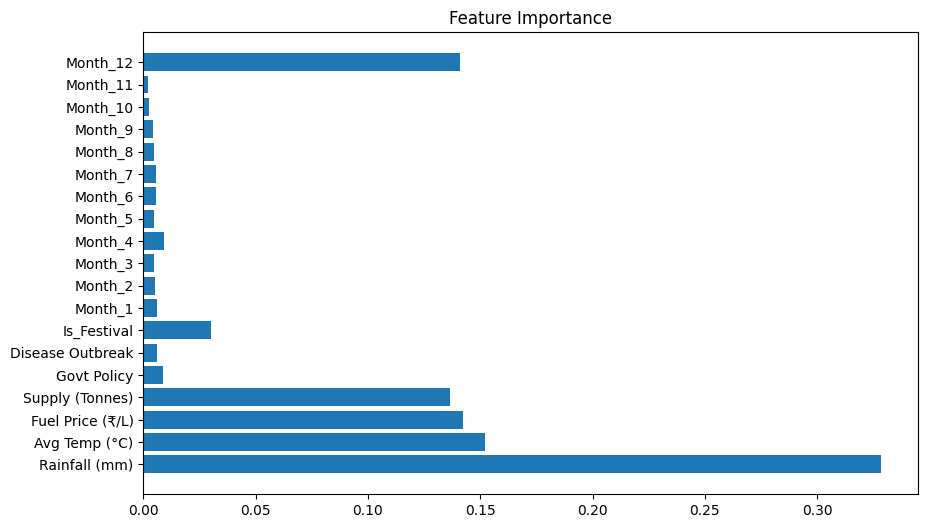

In [ ]:
def train_price_prediction_model(df):
    # Prepare features and target
    features = ['Rainfall (mm)', 'Avg Temp (°C)', 'Fuel Price (₹/L)',
                'Supply (Tonnes)', 'Govt Policy', 'Disease Outbreak',
                'Is_Festival']
    X = pd.get_dummies(df[features + ['Month']], columns=['Month'])
    y = df['Tomato_Price (₹/kg)']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_train

# Train the model
model, X_train = train_price_prediction_model(df)

# Visualize feature importance
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importances)
plt.title("Feature Importance")
plt.show()

In [ ]:
def explain_price_change(features):
    explanations = []

    # Festival impact
    if features['Is_Festival'] == 1:
        festival_row = df[df['Date'] == features['Date']]
        if not festival_row.empty:
            festival = festival_row['Festival'].values[0]
            explanations.append(f"Major price increase due to {festival} festival season")

    # Rainfall impact
    if features['Rainfall (mm)'] > 80:
        explanations.append("Heavy rainfall likely disrupted supply chains")
    elif features['Rainfall (mm)'] < 10:
        explanations.append("Dry conditions may have affected crop yields")

    # Temperature impact
    if features['Avg Temp (°C)'] > 35:
        explanations.append("High temperatures reduced tomato shelf life and supply")
    elif features['Avg Temp (°C)'] < 20:
        explanations.append("Cooler weather improved tomato preservation")

    # Supply impact
    if features['Supply (Tonnes)'] < 100:
        explanations.append("Low market supply driving prices up")

    # Fuel price impact
    if features['Fuel Price (₹/L)'] > 90:
        explanations.append("High fuel prices increased transportation costs")

    # Disease impact
    if features['Disease Outbreak'] == 1:
        explanations.append("Disease outbreak reduced crop yields")

    # Government policy impact
    if features['Govt Policy'] == 1:
        explanations.append("Government policy intervention affected prices")

    # Seasonal patterns
    month = features['Month']
    if month in [10, 11, 12]:
        explanations.append("Monsoon season typically sees higher prices")
    elif month in [3, 4, 5, 6]:
        explanations.append("Summer harvest season typically sees lower prices")

    if not explanations:
        return "Prices are at normal levels for this time of year"

    return "Price changes due to: " + "; ".join(explanations)

In [ ]:
def predict_future_price(model, X_train, future_date, base_features):
    # Prepare features for future date
    future_features = base_features.copy()
    future_features['Is_Festival'] = 1 if is_festival_date(future_date) else 0

    # Create all month columns initialized to 0
    month_columns = [f'Month_{i}' for i in range(1, 13)]
    for col in month_columns:
        future_features[col] = 0

    # Set the appropriate month column to 1
    future_features[f'Month_{future_date.month}'] = 1

    # Remove raw Month feature if present
    if 'Month' in future_features:
        del future_features['Month']

    # Ensure all expected features are present
    for feature in X_train.columns:
        if feature not in future_features:
            future_features[feature] = 0

    # Create DataFrame with correct feature order
    X_sample = pd.DataFrame([future_features])[X_train.columns]

    # Predict price
    price = model.predict(X_sample)[0]

    # Prepare features for explanation
    explanation_features = base_features.copy()
    explanation_features.update({
        'Date': future_date,
        'Is_Festival': future_features['Is_Festival'],
        'Month': future_date.month
    })

    # Generate explanation
    explanation = explain_price_change(explanation_features)

    return price, explanation

In [ ]:
# Example future prediction
future_date = pd.to_datetime("2025-04-05")  # Pongal festival
base_features = {
    'Rainfall (mm)': 15,
    'Avg Temp (°C)': 28,
    'Fuel Price (₹/L)': 95,
    'Supply (Tonnes)': 120,
    'Govt Policy': 0,
    'Disease Outbreak': 0
}

# Make prediction
price, explanation = predict_future_price(
    model,
    X_train,
    future_date,
    base_features
)

# Print results
print(f"Predicted price for {future_date.date()}: ₹{price:.2f}/kg")
print(explanation)

Predicted price for 2025-04-05: ₹36.19/kg
Price changes due to: High fuel prices increased transportation costs; Summer harvest season typically sees lower prices


**Price Trend Over Time**

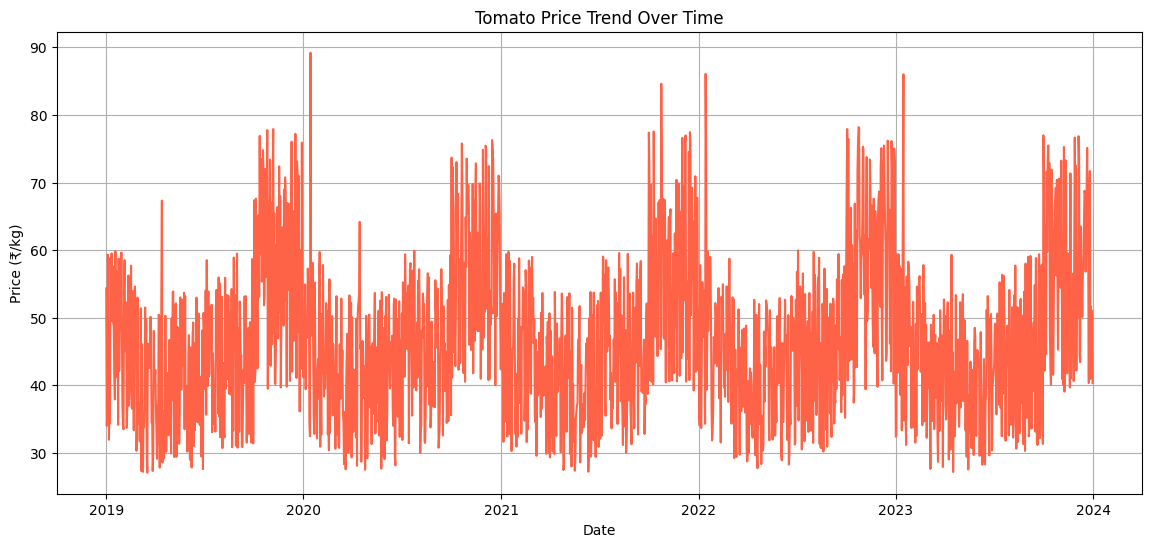

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Tomato_Price (₹/kg)'], color='tomato')
plt.title('Tomato Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price (₹/kg)')
plt.grid(True)
plt.show()

**Seasonal Price Distribution**

<ipython-input-19-918229b34713>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='Tomato_Price (₹/kg)', data=df, palette='autumn')


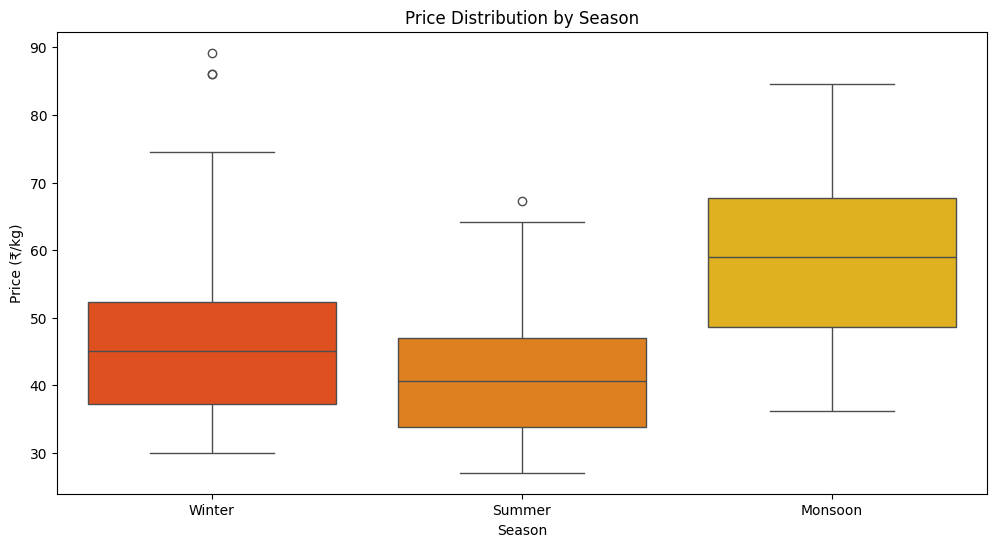

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Season', y='Tomato_Price (₹/kg)', data=df, palette='autumn')
plt.title('Price Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Price (₹/kg)')
plt.show()

**Festival Impact Visualization**

<ipython-input-20-a3a0b2773cdd>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Festival', y='Tomato_Price (₹/kg)', data=festival_prices, ci=None, palette='viridis')
<ipython-input-20-a3a0b2773cdd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Festival', y='Tomato_Price (₹/kg)', data=festival_prices, ci=None, palette='viridis')


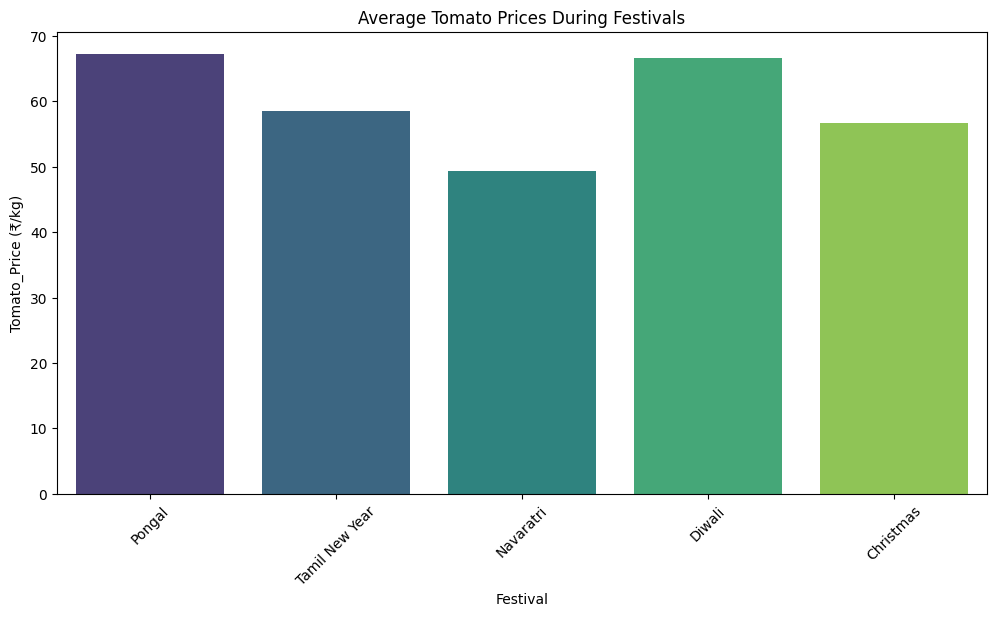

In [ ]:
plt.figure(figsize=(12, 6))
festival_prices = df[df['Festival'].notna()]
sns.barplot(x='Festival', y='Tomato_Price (₹/kg)', data=festival_prices, ci=None, palette='viridis')
plt.title('Average Tomato Prices During Festivals')
plt.xticks(rotation=45)
plt.show()

**Correlation Heatmap**

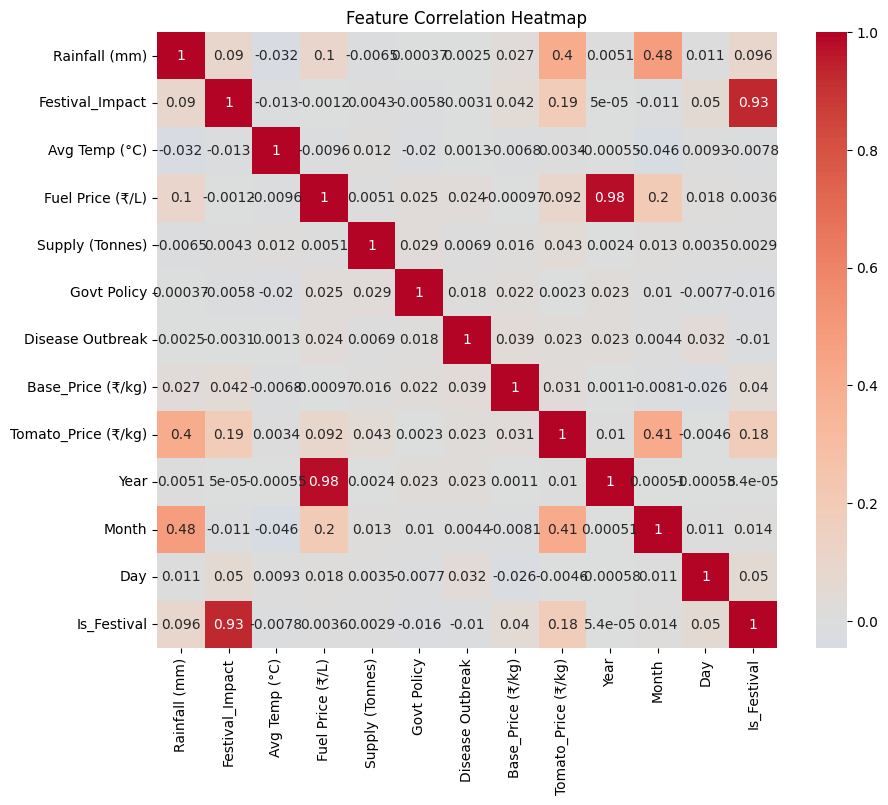

In [ ]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

**Rainfall vs Price Scatter Plot**

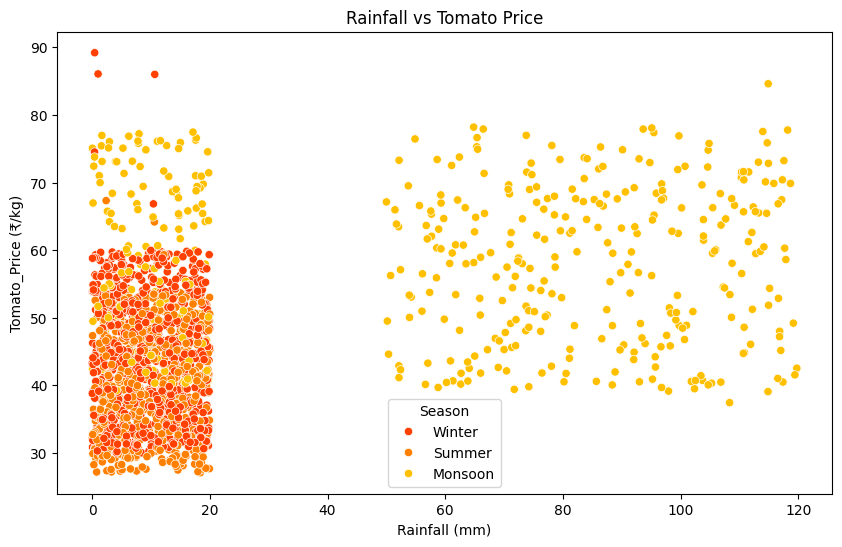

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rainfall (mm)', y='Tomato_Price (₹/kg)', data=df, hue='Season', palette='autumn')
plt.title('Rainfall vs Tomato Price')
plt.show()

**Monthly Average Prices**

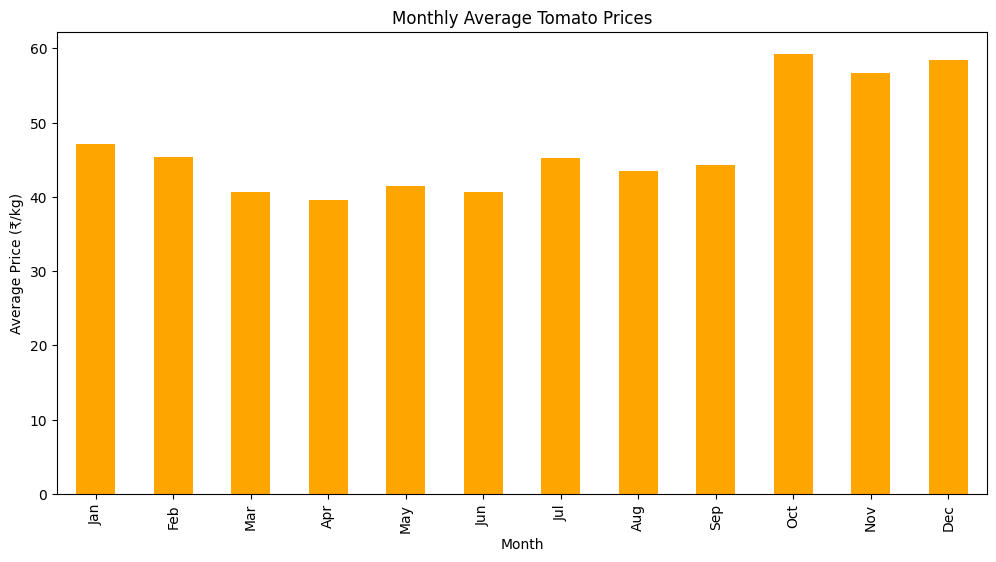

In [ ]:
plt.figure(figsize=(12, 6))
monthly_avg = df.groupby('Month')['Tomato_Price (₹/kg)'].mean()
monthly_avg.plot(kind='bar', color='orange')
plt.title('Monthly Average Tomato Prices')
plt.xlabel('Month')
plt.ylabel('Average Price (₹/kg)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

**Time Series Decomposition**

<Figure size 1200x800 with 0 Axes>

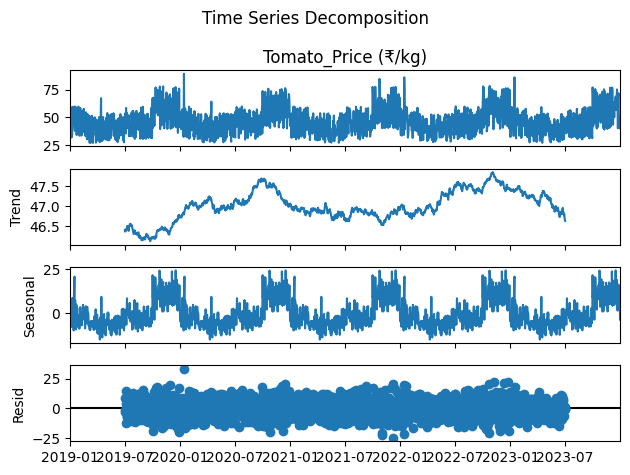

In [ ]:
plt.figure(figsize=(12, 8))
ts_decomposition = seasonal_decompose(df.set_index('Date')['Tomato_Price (₹/kg)'], model='additive', period=365)
ts_decomposition.plot()
plt.suptitle('Time Series Decomposition')
plt.tight_layout()
plt.show()